In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
gfs_file = 'model_data/gfs.t06z.pgrb2.0p25.f000'

gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib",backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})


skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/Users/jturner/miniconda3/envs/FLC/lib/python3.10/site-packages/cfgrib/dataset.py", line 676, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Users/jturner/miniconda3/envs/FLC/lib/python3.10/site-packages/cfgrib/dataset.py", line 607, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,


In [3]:
gfs_ds

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 33, latitude: 721, longitude: 1440)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
  * latitude       (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude      (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
    valid_time     datetime64[ns] ...
Data variables:
    gh             (isobaricInhPa, latitude, longitude) float32 ...
    t              (isobaricInhPa, latitude, longitude) float32 ...
    r              (isobaricInhPa, latitude, longitude) float32 ...
    q              (isobaricInhPa, latitude, longitude) float32 ...
    w              (isobaricInhPa, latitude, longitude) float32 ...
    wz             (isobaricInhPa, latitude, longitude) float32 ...
    u              (isobaricInhPa, latitude, longitude) float32 ...
    v              (isobaricInhPa, latitude, longitude) float32 ...
    absv           (isobaricInhPa, latitude, longitude) float32 ...
    o3mr           (isobaricInhPa, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-05-14T15:57 GRIB to CDM+CF via cfgrib-0.9.1...

In [4]:
georges_bank_profile = gfs_ds.sel(latitude=41, longitude=180-68)
georges_bank_profile

<xarray.Dataset>
Dimensions:        (isobaricInhPa: 33)
Coordinates:
    time           datetime64[ns] ...
    step           timedelta64[ns] ...
  * isobaricInhPa  (isobaricInhPa) float64 1e+03 975.0 950.0 ... 3.0 2.0 1.0
    latitude       float64 41.0
    longitude      float64 112.0
    valid_time     datetime64[ns] ...
Data variables:
    gh             (isobaricInhPa) float32 ...
    t              (isobaricInhPa) float32 ...
    r              (isobaricInhPa) float32 ...
    q              (isobaricInhPa) float32 ...
    w              (isobaricInhPa) float32 ...
    wz             (isobaricInhPa) float32 ...
    u              (isobaricInhPa) float32 ...
    v              (isobaricInhPa) float32 ...
    absv           (isobaricInhPa) float32 ...
    o3mr           (isobaricInhPa) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP
    history:                 2024-05-14T15:57 GRIB to CDM+CF via cfgrib-0.9.1...

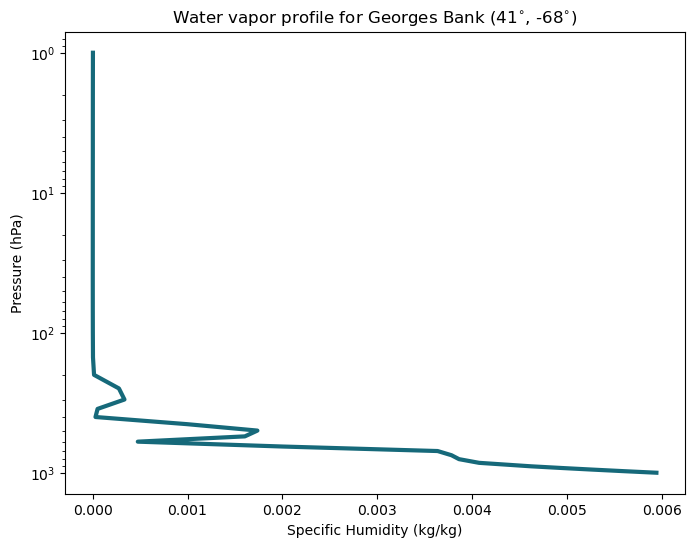

In [5]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.plot(georges_bank_profile.q, georges_bank_profile.isobaricInhPa, c='#16697A', linewidth=3)

ax.set_title('Water vapor profile for Georges Bank (41$^{\circ}$, -68$^{\circ}$)')
ax.set_xlabel('Specific Humidity (kg/kg)')
ax.set_ylabel('Pressure (hPa)')
plt.yscale('log')
plt.gca().invert_yaxis()
plt.show()

In [6]:
georges_bank_profile.isobaricInhPa.values*100

array([100000.,  97500.,  95000.,  92500.,  90000.,  85000.,  80000.,
        75000.,  70000.,  65000.,  60000.,  55000.,  50000.,  45000.,
        40000.,  35000.,  30000.,  25000.,  20000.,  15000.,  10000.,
         7000.,   5000.,   4000.,   3000.,   2000.,   1500.,   1000.,
          700.,    500.,    300.,    200.,    100.])

Calculate the water vapor mass density:
* this is described in RadTran Miller presentation notes
* $r_g$ is the mixing ratio of water vapor, averaged between the layers ($p_1$ and $p_2$)
* mass density ($u$) is in kg m-2

$$
u(p_1, p_2) = \frac{1}{g}\int_{p_2}^{p_1} r_g dp
$$

In [7]:
g = 9.807 #m s-2
u = []

for i in range(len(georges_bank_profile.isobaricInhPa.values)-1):
    p1 = georges_bank_profile.isobaricInhPa.values[i]*100 #kg s-2 m-1
    p2 = georges_bank_profile.isobaricInhPa.values[i+1]*100 #kg s-2 m-1
    dp = p1-p2

    r_g = (georges_bank_profile.q.values[i] + georges_bank_profile.q.values[i+1]) / 2 #kg kg-1

    u.append((1/g)*r_g*dp) #kg m-2



/var/folders/pd/x01_y6d52zj47w6_m5_h_8f80000gr/T/ipykernel_39253/210649174.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(minor='off',labels=yticklabels)


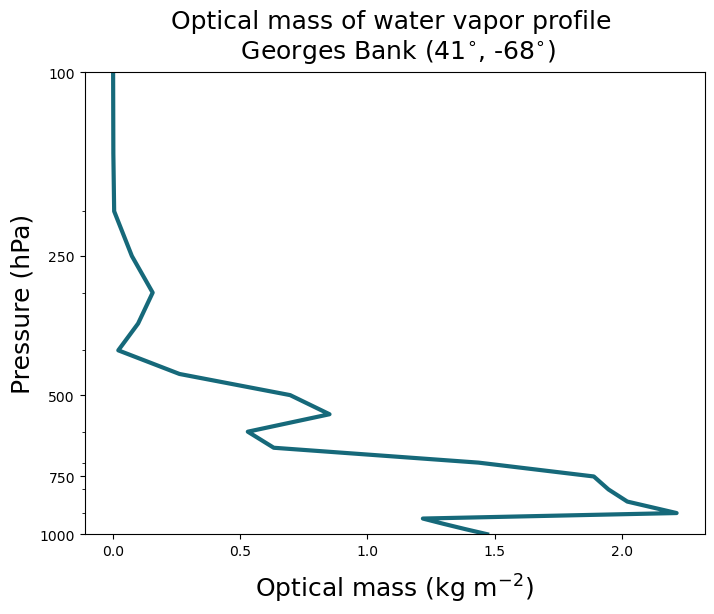

In [8]:
fig, ax = plt.subplots(1, figsize=(8,6))

ax.plot(u ,georges_bank_profile.isobaricInhPa.values[:-1], c='#16697A', linewidth=3)

ax.set_title('Optical mass of water vapor profile \n Georges Bank (41$^{\circ}$, -68$^{\circ}$)', size=18, pad=10)
ax.set_xlabel('Optical mass (kg m$^{-2}$)', size=18, labelpad=10)
ax.set_ylabel('Pressure (hPa)', size=18)

#---Y-labels took some wrangling
plt.yscale('log')
ax.set_ylim([1000,100])
ax.set_yticks([1000,750,500,250,100])
yticklabels = ['1000','750','500','250','100']
ax.set_yticklabels(yticklabels)
plt.gca().set_yticklabels(minor='off',labels=yticklabels)

plt.show()

In [9]:
#---Create a dictionary for the variable values
data = {
    'Optical Mass': u,
    'Temperature': georges_bank_profile.t.values[:-1]
}

# Create DataFrame with pressures as index
optical_mass_df = pd.DataFrame(data, index=georges_bank_profile.isobaricInhPa.values[:-1])

optical_mass_df

,Optical Mass,Temperature
1000.0,1.470607,298.361359
975.0,1.384706,296.960083
950.0,1.300575,295.527649
925.0,1.218317,294.047638
900.0,2.215604,292.535461
850.0,2.021903,288.929932
800.0,1.947671,284.115479
750.0,1.890161,278.982178
700.0,1.437260,273.714355
650.0,0.632121,269.702179


In [10]:
optical_mass_df.to_pickle('tables/optical_mass_example')